# Vessel segmentation in retina fundus images
<img src="images/21_training.png" width="250" height="250" align="right">
In this assignment we will return to the taks of segmentation of vessels in retina fundus images from assignment 2. This time however, we will solve the problem using deep learning. More specifically, we will explore different **fully convolutional neural networks**.

## Teaching assistants

- Bart Liefers: Bart.Liefers@radboudumc.nl
- Ajay Patel: Ajay.Patel@radboudumc.nl

## Students
Please fill in this cell with your name and e-mail address. This information will be used to grade your assignment.

* Brian Westerweel, b.westerweel@student.ru.nl
* Jeffrey Luppes, j.luppes@student.ru.nl
* Gijs van der Meijde, g.vandermeijde@student.ru.nl

## Data
For this assignment we will use data from the publicly available DRIVE dataset (http://www.isi.uu.nl/Research/Databases/DRIVE/).
The DRIVE dataset consists of 40 images, 20 used for training and 20 used for testing. Each case contains:
* a fundus (RGB) image
* a binary mask, which indicates the area of the image that has to be analyzed (removing black background)
* manual annotations of retinal vessels, provided as a binary map

## Fully convolutional neural networks
A direct, but naive approach to pixel classification using a CNN would be to extract a patch around every pixel and assign the output back to the pixel location. This is computationally inefficient, because when we move our patch by
one pixel to classify the next pixel, a large proportion of the pixels of the new patch are identical to the previous patch, and we would apply the same convolutions many times over.

A trick to obtain a label for all pixels efficiently, is to define a network architecture that does not include a fully connected (or dense) part. As the network only contains convolutional filters, the spatial structure is kept intact. Therefore the whole network can be thought of as a single large convolutional filter that can be applied to the whole image at once. This speeds up the classification greatly and allows full image segmentation in milliseconds!

During training the same trick can be applied: use a full image as input, and train on all pixel-labels synchronously. In this assignment however, we will initially train the network on patches extracted from random locations in the training data.
There are several reasons why this could be useful. To name a few:
* In some applications you don't have a label for all pixels, so patches are a necessity.
* Less memory is needed during training which may speed up training time dramatically.
* Per training iteration we can use patches from different source images, and apply augmentations on a patch-base, which increases diversity during training, leading to faster convergence and better results.
* Patch sampling allows us to control a possible class imbalancing in an intuitive way.
* By sampling more frequently from more difficult locations, we could control the difficulty of the training procedure carefully.


## Tasks 
The tasks you have to perform for this assignment are:
1. Create a patch-extractor and a batch-creator to generate training data for the network **(20 pts)**
2. Implement and train different fully convolutional neural networks **(50 pts)**
3. Perform some experiments to improve performance of your model **(30 pts)**  
There will be another additional **(10, 8, 6, 4, 2) pts** for the top 5 best scoring submissions to grand-challenge.

## Load data

Let's get started by importing libraries needed for this assignment:

In [1]:
import os
import shutil
import random
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

from scipy.ndimage.interpolation import rotate
from sklearn.metrics import cohen_kappa_score

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D
from keras import optimizers
from keras.optimizers import SGD
from keras import backend as K
import keras.callbacks

C:\Users\Jeff\Anaconda2\envs\py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## If the Jupter server runs on Cartesius

In [2]:
# Path that points to the local copy of training data
data_folder = '/projects/0/ismi2018/DRIVE'

## If the Jupyter server runs on your computer

In [2]:
# Script to download the dataset to your local computer
import requests
from tqdm import tqdm_notebook
import zipfile
link = 'https://surfdrive.surf.nl/files/index.php/s/lgIuEFPPETtM2ZP/download'
file_name = "DRIVE.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove(file_name)
data_folder = 'DRIVE'

HBox(children=(IntProgress(value=1, bar_style='info', description='Downloading data', max=1), HTML(value='')))

## Create a training and validation set
We will load all training images into memory, and then divide them into two sets: one (called the **training set**) to optimize the weights of the network, and one (**validation set**) to monitor the performance of the network on unseen data.

In [3]:
def get_file_list(path, ext=''):
    return sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith(ext)])

def load_img(path):
    return np.array(Image.open(path))

train_img_files = get_file_list(os.path.join(data_folder, 'training', 'images'), 'tif')
train_msk_files = get_file_list(os.path.join(data_folder, 'training', 'mask'), 'gif')
train_lbl_files = get_file_list(os.path.join(data_folder, 'training', '1st_manual'), 'gif')

train_imgs = [load_img(f) for f in train_img_files]
train_msks = [load_img(f) for f in train_msk_files]
train_lbls = [load_img(f) for f in train_lbl_files]

# we also load test image and masks, to be used later
test_img_files = get_file_list(os.path.join(data_folder, 'test', 'images'), 'tif')
test_msk_files = get_file_list(os.path.join(data_folder, 'test', 'mask'), 'gif')

test_imgs = [load_img(f) for f in test_img_files]
test_msks = [load_img(f) for f in test_msk_files]

Define a folder where to store results on the test set:

In [4]:
# define output folder
result_output_folder = './results'
if not os.path.exists(result_output_folder):
    os.makedirs(result_output_folder)

Define how many images will be used for validation:

In [5]:
# Define the number of validation images here:
n_validation_imgs = 4

Now we define a class ```DataSet``` that will be used to handle training and validation datasets:

In [6]:
class DataSet:
    
    def __init__(self, imgs, msks, lbls=None):
        self.imgs = imgs
        self.msks = msks
        self.lbls = lbls
    
    def show_image(self, i):
        if self.lbls != None:
            f, axes = plt.subplots(1, 3)
            for ax, im, t in zip(axes, 
                                 (self.imgs[i], self.msks[i], self.lbls[i]), 
                                 ('RGB image', 'Mask','Manual annotation')):
                ax.imshow(im, cmap='gray')
                ax.set_title(t)
        else:
            f, axes = plt.subplots(1, 2)
            for ax, im, t in zip(axes, 
                                 (self.imgs[i], self.msks[i]), 
                                 ('RGB image', 'Mask')):
                ax.imshow(im, cmap='gray')
                ax.set_title(t)
        plt.show()

In [7]:
# use the first images as validation
validation_data = DataSet(train_imgs[:n_validation_imgs], train_msks[:n_validation_imgs], train_lbls[:n_validation_imgs])

# the rest as training
train_data = DataSet(train_imgs[n_validation_imgs:], train_msks[n_validation_imgs:], train_lbls[n_validation_imgs:])

Let's inspect some of the loaded images:

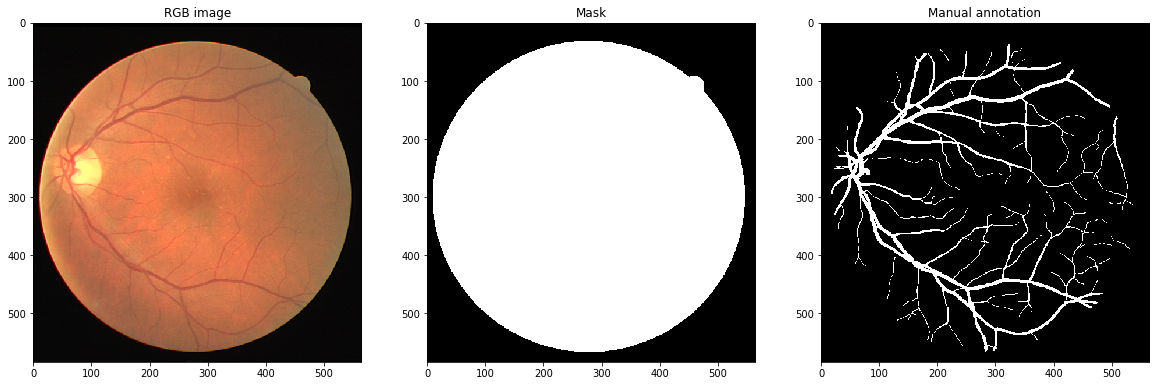

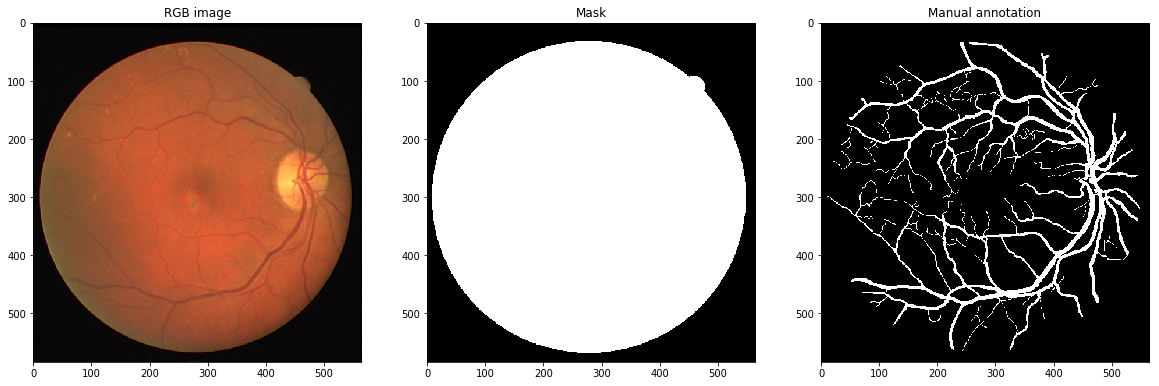

In [8]:
matplotlib.rcParams['figure.figsize'] = (20, 12)
validation_data.show_image(0) # change this parameter to try a few images
train_data.show_image(0) # change this parameter to try a few images

# Build a patch extractor (10pts)
Differently from what we've done in the past two weeks, in this assignment we are going to implement a ```PatchExtractor``` class, which extract random patches from a list of images.
This means that you don't need to create a dataset beforehand and then use it to train you network, but you will just have a list of training images available, and patches will be extracted **on-the-fly** during training.
This strategy allows to save time in the preparation of your *static* dataset, and allows the use of a *dynamic* generation of batches, where data augmentation can also be applied on-the-fly.
Note that this approach allows to test different strategies of data augmentation without the need for making a new dataset from scratch all the time.

For now, we will only implement one kind of data augmentation in the ```get_patch``` method: **horizontal flipping**. 
The event will occur at random, meaning that during patch extraction, some of the extracted patches will be randomly transformed. 

Later in the assignment you will also use the ```get_image``` method, which also performs rotation-augmentations.

In [9]:
# Implement the get_patch method below:

class PatchExtractor:

    def __init__(self, patch_size, max_rotation=30, flipping=True):
        self.patch_size = patch_size 
        self.flipping = flipping
        self.max_rotation = max_rotation
        
        
    def get_patch(self, image, location):
        ''' 
        image: a numpy array representing the input image
        location: a tuple with an y and x coordinate
        
        return a patch from the image at `location`, representing the top left corner of the patch
        if self.flipping = True, there is a 50% chance the patch is horizontally flipped   
        we will not rotate it or perform other augmentations for now to speed up the training process
        '''
        y, x = location      
        h, w = self.patch_size
        
        ### Your code starts here
        
        # - patch should be a numpy array of size <h, w>
        # - the patch should be normalized (intensity values between 0-1)
        image_copy = image.copy()
        patch = image_copy[y:y+h, x:x+w]/255

        # - if self.flipping = True, there should be a 50% chance to apply a horizontal flip to the patch  
        if self.flipping:
            do_flipping = bool(random.getrandbits(1))
            
        # - if do_flipping == True, flip the patch horizontally
        if do_flipping:
            patch = patch[:, ::-1]
        
        ### Your code ends here
        
        return patch
    
    def get_image(self, image, label):
        ''' 
        image: a numpy array representing the input image
        label: a numpy array representing the labels corresponding to input image
        return a rotated and flipped version of the image and corresponding label
        '''
        angle = 2 * (random.random() - 0.5) * self.max_rotation
        image_out = rotate(image, angle, reshape=False, order=0) / 255
        label_out = rotate(label, angle, reshape=False, order=0) > 0

        flip = self.flipping and random.random() > 0.5
        if flip:
            image_out = np.fliplr(image_out)
            label_out = np.fliplr(label_out)
            
        return image_out, label_out

Let's test our patch extractor! By repeatedly executing the cell below, you should be able to see different augmentations of the same patch. The dot in the images represents the center of the patch, which is the pixel we are going to classify.

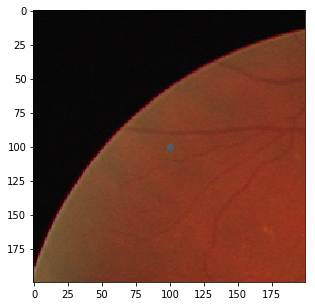

In [10]:
patch_size = (200, 200) # Set the size of the patches as a tuple (height, width) 

img_index = 5 # choose an image to extract the patch from
location = (25, 25) # define the location of the patch (y, x) - coordinate

patch_extractor = PatchExtractor(patch_size, 30, True)

matplotlib.rcParams['figure.figsize'] = (5, 5)
plt.imshow(patch_extractor.get_patch(train_data.imgs[img_index], location))
plt.scatter(*[p/2 for p in patch_extractor.patch_size], alpha=0.5)
plt.show()

# Build a batch creator (10pts)

Now it's time to create a BatchCreator. The BatchCreator will allow us to generate batches to train on. These batches contain a set of (class-balanced) samples or patches, and their corresponding labels. The data returned by the ```BatchCreator``` can directly be fed into the neural network for training or classification. 

Firs we define a usefull function for padding images with a zero-border:

In [11]:
def pad(images, patch_size):
    ''' images: list of images (numpy arrays)
    returns a padded version of the images, with a border of half the patch_size around each image
    '''
    half_py, half_px = [p//2 for p in patch_size]
    paddings = ((0, 0), (half_py, half_py), (half_px, half_px), (0, 0))
    return np.pad(np.array(images), pad_width=paddings, mode='constant') 

Now, implement the ```create_batch``` method in the ```BatchCreator``` class. It should return the patches and labels (```x_data``` and ```y_data```) in the right structure for direct use in Keras (do not confuse the variables (```x,y```) used for coordinates and (```x_data```, ```y_data```) used for images and labels).

In [12]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset):
        self.patch_extractor = patch_extractor
        
        # the images are padded with half the patch-size around the border
        # this way, we don't risk extracting patches from the border, that extend beyond the original image
        self.imgs = pad(dataset.imgs, patch_extractor.patch_size)
        self.lbls = pad(np.expand_dims(dataset.lbls, 3), patch_extractor.patch_size)
        
        # pre calculate the positive and negative indices
        self.p_idxs = np.where(np.array(dataset.lbls) > 0)
        self.n_idxs = np.where((np.array(dataset.msks) > 0) & ~(np.array(dataset.lbls) > 0))

    def create_batch(self, batch_size):
        '''
        returns a class-balanced array of patches (x) with corresponding labels (y) in one-hot structure
        '''
        # unpack the positive and negative indices
        pi, py, px = self.p_idxs
        ni, ny, nx = self.n_idxs
        
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 3))
        y_data = np.zeros((batch_size, 1, 1, 2)) # one-hot encoding
        
        ### Your code starts here
        # fill x_data and y_data with the correct data (use both positive and negative examples!):
        
        for sample in range(batch_size):
            random_index = np.random.choice(len(pi))
            pos = bool(random.getrandbits(1))
            img_index = 0
            location = (0, 0)
            if pos:
                img_index = pi[random_index]
                location = (py[random_index], px[random_index])
                y_data[sample,0,0,1]=1
            else:
                img_index = ni[random_index]
                location = (ny[random_index], nx[random_index])
                y_data[sample,0,0,0]=1
                
            x_data[sample] = self.patch_extractor.get_patch(self.imgs[img_index], location)
        
        ### Your code ends here
          
        return x_data, y_data
    
    def create_image_batch(self):
        '''
        returns a single augmented image (x) with corresponding labels (y) in one-hot structure
        '''
        random_index = np.random.choice(len(self.imgs))
        img, lbl = self.imgs[random_index], self.lbls[random_index]
        patch_img, patch_lbl = patch_extractor.get_image(img, lbl)
        
        # adds a sample-dimension
        x_data = np.expand_dims(patch_img, 0)

        # calculate the dimensions for the label
        h, w, _ = patch_lbl.shape
        ph, pw = [p//2 for p in self.patch_extractor.patch_size]
       
        # encodes the label in one hot structure
        y_data = np.zeros((1, h - 2 * ph, w - 2 * pw, 2))
        y_data[0, :, :, 1][patch_lbl[ph:-ph, pw:-pw, 0]] = 1
        y_data[0, :, :, 0][~patch_lbl[ph:-ph, pw:-pw, 0]] = 1
        
        return x_data, y_data
        
    def get_generator(self, batch_size):
        '''returns a generator that will yield batches infinitely'''
        while True:
            yield self.create_batch(batch_size)
            
    def get_image_generator(self):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch()

Let's test our BatchCreator! Half of the patches in the visualization below should represent vessel patches (having a vessel in the center of the patch). The other half should represent background patches (no vessel in the center of the patch). The dot in the images represents the center of the patch, which is the pixel we are going to classify.

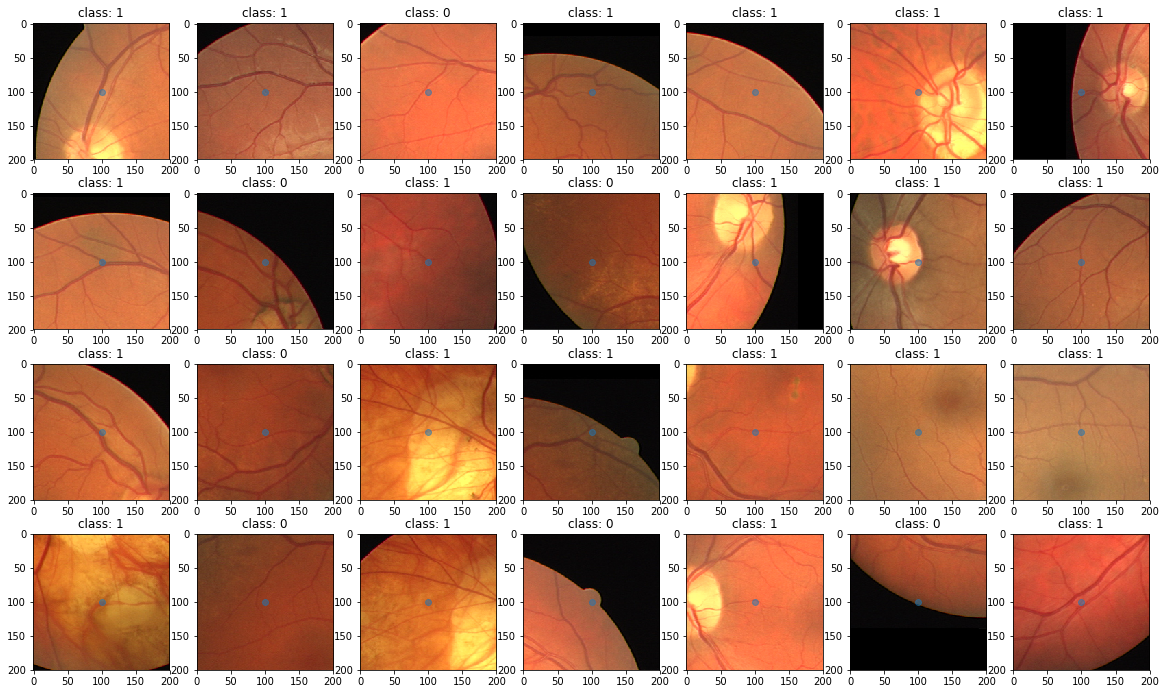

In [13]:
batch_creator = BatchCreator(patch_extractor, train_data)

# create a batch
x, y = batch_creator.create_batch(28)
# visualize it
matplotlib.rcParams['figure.figsize'] = (20, 12)
f, axes = plt.subplots(4, 7)
i = 0;
for ax_row in axes:
    for ax in ax_row:
        ax.imshow(x[i])
        ax.set_title('class: {}'.format(np.argmax(y[i, 0, 0])))
        ax.scatter(*[p/2 for p in patch_extractor.patch_size], alpha=0.5)
        i += 1
plt.show()

# Build the first fully convolutional network (10pts)

We will now start with defining our initial network architecture in Keras.
What is important to train a fully convolutional neural network on patches, is that **the size of the feature maps within the network goes down to exactly 1x1 for the final feature map**. 
We will therefore use **valid** convolutions (in contrast to **same** convolutions) and pooling operations to reduce the size of the feature maps.
This requires some computation, but luckily it is pretty straightforward:  

If we define:
```
i = Input featuremap size
o = Output featuremap size 
f = Convolution filter size 
m = Pooling size
```
Then:

Output size of a feature map after convolution with a convolution filter of size f:
```python
o = i - (f - 1)
```
Output size of a feature map after pooling of size m:
```python
o = floor(i/m)
```

### Model definition
Let's define a baseline model:
* input layer 
* 32 filters of 4x4
* 32 filters of 3x3
* pooling
* 64 filters of 3x3
* 64 filters of 3x3
* pooling
* 128 filters of 3x3
* 64 filters of 1x1
* 2 filters of 1x1 

After every convolution we will apply a **relu** non-linearity. The last layer should have a **softmax** non-linearity to transform the 2 filters in probabilities for the vessel and background class.  

The reason to start with the less common 4x4 convolutions, is that we wish to define a patch-size that has an odd number of pixels (so that we can define a single center pixel that corresponds with the label). At the same time, we want the input to the pooling layers to be even, so we don't exclude the pixels around the border. The 1x1 convolutions in the deeper layers act as the dense part of a classification network: we no longer take contextual information into account, but only do recombination of features. The final two filters represent the two classes background and vessel.

**NOTE**: Since a fully-convolutional network can process input patches of (almost) any size, we should not hard-code a specific size in the ```Input``` layer. The way of doing this is to define the height and the width of input patches as ```None```. The same trick is used to avoid specifying a mini-batch size, which can be changed arbitrarily. We do hard-code the presence of 3 channels, because we are going to process RGB images.

In [14]:
## DEFINE THE ABOVE DESCRIBED MODEL HERE
x_in = Input(batch_shape=(None, None, None, 3)) # DO NOT REPLACE None HERE! It is actually needed!!!

### Your code starts here
x = Conv2D(32, (4, 4), activation='relu')(x_in)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(64, (1, 1), activation='relu')(x)

x_out = Conv2D(2, (1, 1), activation='softmax')(x) # this is the output fo your network, used later on in this notebook

### Your code ends here

#### Question
What patch-size do we need to define in order to get an output size of 1x1 for the above network definition?

* *1x1   -> conv(1x1) = 1x1*
* *1x1   -> conv(1x1) = 1x1*
* *1x1   -> conv(3x3) = 3x3*
* *3x3   -> pool(2x2) = 6x6*
* *6x6   -> conv(3x3) = 8x8*
* *8x8   -> conv(3x3) = 10x10*
* *10x10 -> pool(2x2) = 20x20*
* *20x20 -> conv(3x3) = 22x22*
* *22x22 -> conv(4x4) = **25x25***

## Define the loss and compile the model (10 pts)

Although Keras has many built-in cost-functions, we will define our own here as an exercise. 
It takes as input two tensors: ```y_true``` and ```y_pred```, which have shape ```(samples, height, width, classes)``` and should return a single value represting the loss of this batch. For this assignment we will use the cross-entropy (sometimes also referred to as log-loss). In this case it is equivalent to the mean log of the differences between true label and the predicted label.

Note that the inputs (```y_true, y_pred```) are not numpy arrays, but Tensorflow tensor. This means we cannot apply numpy operations on them! Luckily, there is a very similar API we can use in Tensorflow, which we can import through ```keras.backend```. In this assignment, this backend is loaded as ```K```, so you can use ```K.mean, K.sum, K.log``` etc., where you would otherwise use ```np.mean, np.sum, np.log```

***Note: *** if you don't succeed in finding a correct implementation, you can change the reference to ```loss_function``` in ```model_1.compile``` to ``` 'categorical_crossentropy' ```

In [15]:
model_1 = Model(x_in, x_out)

def loss_function(y_true, y_pred):
    # calculate the log-loss \
#     a = K.log(y_true * y_pred)
    loss = - K.mean(K.log(K.sum(y_true*y_pred, axis=-1)))
#     loss = - K.mean(y_true * K.log(y_pred))
    
    
    return loss

# define the optimizer. For the initial experiments we will use SGD, later you can try to improve upon this
learning_rate = 0.01
optimizer = SGD(learning_rate)

# uncomment if you wish to skip implementing your own cost-function
# loss_function = 'categorical_crossentropy'
model_1.compile(optimizer, loss_function)

## Logging:
Here we define a logger class, that will store usefull data througout the training procedure:

In [16]:
def downscale(images, stride):
    # Downscale if the network does pooling
    return np.array(images)[:, ::stride, ::stride]

def calculate_dice(x, y):
    '''returns the dice similarity score, between two boolean arrays'''
    return 2 * np.count_nonzero(x & y) / (np.count_nonzero(x) + np.count_nonzero(y))
    
class Logger(keras.callbacks.Callback):

    def __init__(self, validation_data, patch_size, stride=1):
        self.val_imgs = pad(validation_data.imgs, patch_size) / 255.
        self.val_lbls = downscale(validation_data.lbls, stride) > 0
        self.val_msks = downscale(validation_data.msks, stride) > 0
         
        self.losses = []
        self.dices = []
        self.best_dice = 0
        self.best_model = None
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    
    def on_epoch_end(self, batch, logs={}):
        dice = self.validate()
        self.dices.append([len(self.losses), dice])
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_model = self.model.get_weights()
        self.plot()
           
    def validate(self):
        predicted_lbls = self.model.predict(self.val_imgs, batch_size=1)[:,:,:,1]>0.5
        x = self.val_lbls[self.val_msks]
        y = predicted_lbls[self.val_msks]
        return calculate_dice(x, y)
    
    def plot(self):
        clear_output()
        N = len(self.losses)
        train_loss_plt, = plt.plot(range(0, N), self.losses)
        dice_plt, = plt.plot(*np.array(self.dices).T)
        plt.legend((train_loss_plt, dice_plt), 
                   ('training loss', 'validation dice'))
        plt.show()

## Train the network! (5 pts)

Now you have to define some parameters, which are needed to train your network:

In [21]:
patch_size = (25, 25) # should be a tuple of width, height corresponding to your network architecture 
batch_size = 100 # pick a proper batch-size (something in the range 32-128 would do)

# To let the network converge to a reasonable state, steps_per_epoch * epochs should be around 5000 to 10000
steps_per_epoch = 20 # how many steps per epoch?
epochs = 250 # how many epochs? 20*250 = 5000

flipping = True

To do validation during training, we need to define the downscaling factor (which we call ```stride```) due to pooling of our network. That is: how much lower is the resolution of the output compared to the input?

In [18]:
stride = 4 # what is the downscaling factor of your network? --> 2x first pooling and 2x second pooling

Now we use all the classes defined so far to initialize data that will be used for training and validation.

In [19]:
patch_extractor = PatchExtractor(patch_size)
batch_creator = BatchCreator(patch_extractor, train_data)
generator = batch_creator.get_generator(batch_size)
logger_1 = Logger(validation_data, patch_size, stride=stride)

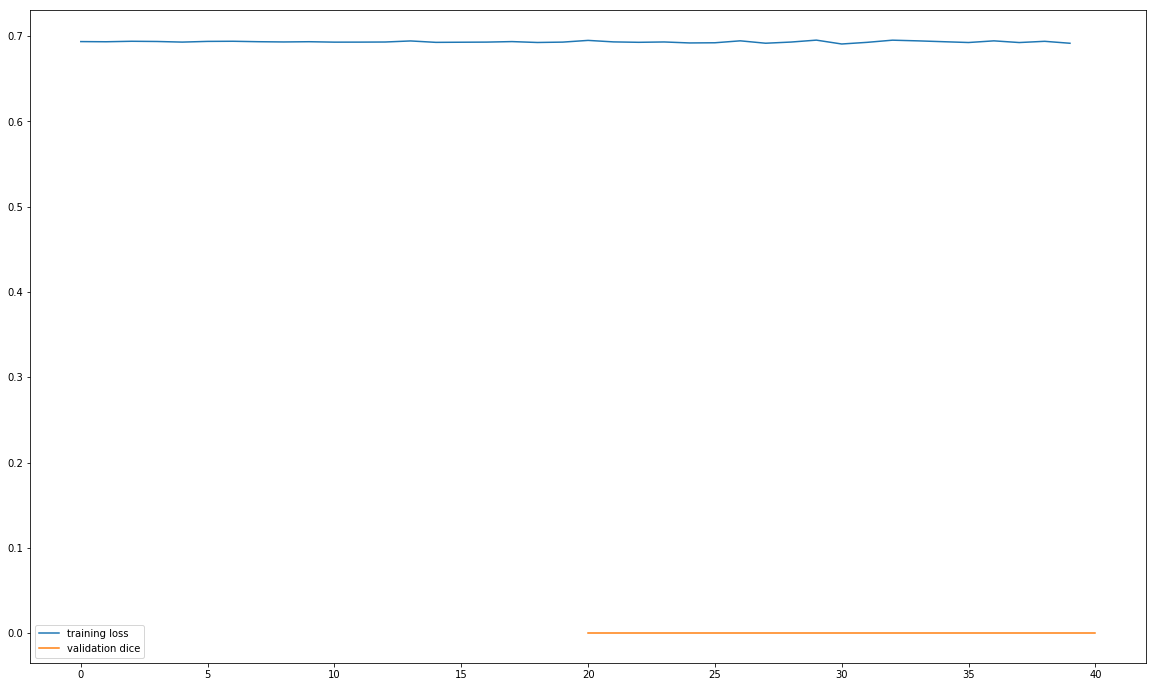

In [20]:
model_1.fit_generator(generator=generator, 
                      steps_per_epoch=steps_per_epoch, 
                      epochs=epochs, 
                      callbacks=[logger_1])

## Check results on the validation set
Now let's apply the trained model to the validation data to get an idea how well the network is performing. We will define the function ```process_basic``` below to apply the model to a dataset. 

In [22]:
def process_basic(model, dataset, stride=1):
    
    # pad the original images, so we don't loose the borders in our output
    imgs = pad(dataset.imgs, patch_size) / 255.
    
    # downscale the label and masks if needed (to get the same resolution as the output)
    lbls = downscale(dataset.lbls, stride) > 0
    msks = downscale(dataset.msks, stride) > 0
    
    # apply our model to the images
    output = model.predict(imgs, batch_size=1)[:,:,:,1]

    return lbls, msks, output

We will use the following function to visually inspect the results and calculate a dice-score for each image:

In [23]:
def check_results(imgs, lbls, msks, output, threshold=0.5):

    dices = []
    for i, (img, lbl, msk, raw_output) in enumerate(zip(imgs, lbls, msks, output)):
        
        final_output = raw_output > threshold
        
        dice = calculate_dice(final_output[msk], lbl[msk])
        dices.append(dice)
        print('image:', i, 'dice', dice)
        
        # plot the results
        matplotlib.rcParams['figure.figsize'] = (15, 6)
        f, axes = plt.subplots(1, 4)
        for ax, im, t in zip(axes, 
                             (img, raw_output, final_output, lbl), 
                             ('RGB image', 'Soft prediction', 'Thresholded', 'Ground truth')):
            ax.imshow(im, cmap='gray')
            ax.set_title(t)
        plt.show()
        
    print('mean dice', np.mean(dices))

Now we load the best model (based on the validation dice score during training), and check the results:

In [24]:
model_1.set_weights(logger_1.best_model)
lbls, msks, output =  process_basic(model_1, validation_data, stride=stride)
check_results(validation_data.imgs, lbls, msks, output, threshold=0.25)

TypeError: 'NoneType' object is not subscriptable

## Shift and stitch

You can see that the label image predicted by our network has a **much lower resolution** then the input image.
This is due to the pooling operations that we used in our network. 
A trick to get full resolution output back is to use shift and stitch, where we apply the network multiple times to the same input image, but shifted by a pixel every time. The output images are then stitched back together to obtain a full resolution image.

Because recent advances have made this technique more or less obsolete and implementation can be cumbersome, we will provide an implementation of the ```shift_and_stitch``` function for you, that you can use to obtain a full resolution output image.

In [25]:
def shift_and_stitch(model, x, patch_size, stride, n_classes):
    pad_h, pad_w = [p//2 for p in patch_size]
    stride_h, stride_w = stride
    n_batches, height, width, n_channels = x.shape

    target_shape = n_batches, height + 2 * pad_h, width + 2 * pad_w, n_channels
    y = np.zeros((n_batches, height + stride_h, width + stride_h, n_classes))
    for r in range(stride_h):
        for c in range(stride_w):
            x_in = np.zeros(target_shape)
            h_start, w_start = pad_h - r, pad_w  - c
            x_in[:, h_start:h_start + height, w_start: w_start + width] = x
            y_out = model.predict(x_in, batch_size=1)
            _, h, w, _ = y_out.shape
            y[:, r:h*stride_h:stride_h, c:w*stride_w:stride_w,:] = y_out
    return y[:,:height,:width,1]

In [26]:
def process_shift_and_stitch(model, dataset, patch_size, stride):
    imgs = np.array(dataset.imgs) / 255.
    lbls = np.array(dataset.lbls) > 0
    msks = np.array(dataset.msks) > 0
        
    output = shift_and_stitch(model, imgs, patch_size, (stride, stride), 2)
    return lbls, msks, output

image: 0 dice 0.197002997002997


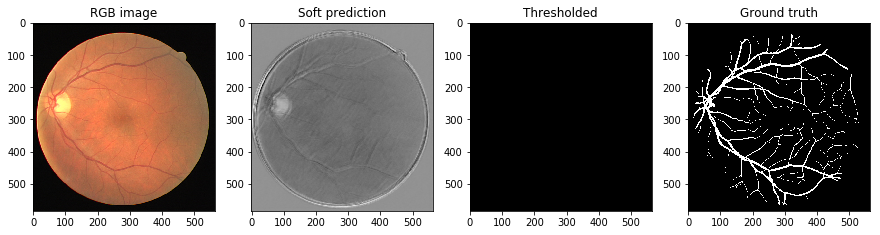

image: 1 dice 0.23146889539625456


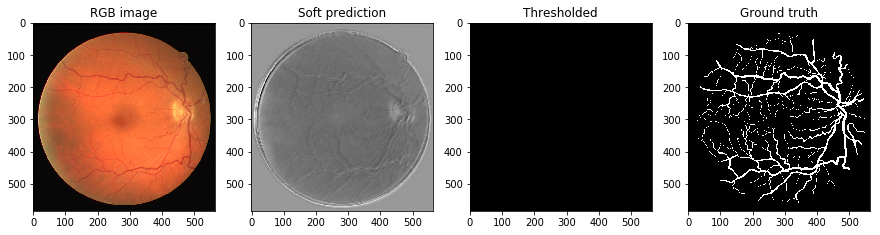

image: 2 dice 0.17378081720361263


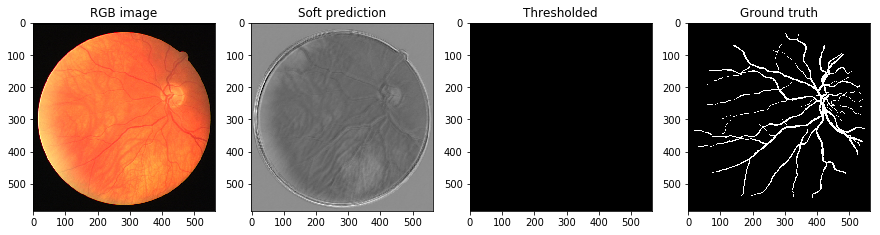

image: 3 dice 0.2873945724803622


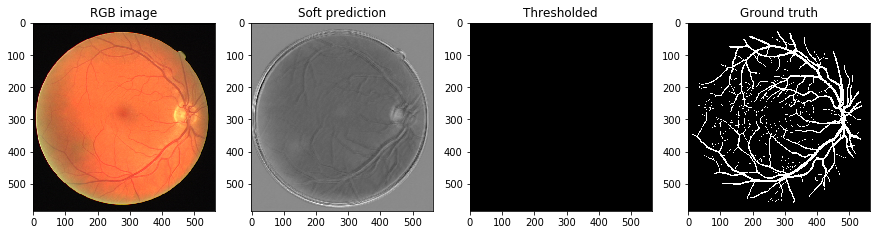

mean dice 0.2224118205208066


In [27]:
lbls, msks, output = process_shift_and_stitch(model_1, validation_data, patch_size, stride)
check_results(validation_data.imgs, lbls, msks, output, threshold=0.3)

Now we get a full resolution output map, which looks much smoother already!

#### Question
Looking at the images above, the initial threshold of 0.5 is probably not ideal for optimal performance. Would you need a higher or a lower threshold? What could be a reason for this? (hint: think of the way we present data during trainig)

*Your answer here*

## Process the test set and submit to grand-challenge.org

Now you can process images in the test set and submit your results to grand-challenge.
First, we define the functions ```process_test_set``` and ```process_test_set_shift_and_stitch```, which you can also reuse for future experiments in this notebook:

In [28]:
def process_test_set(model, logger, test_imgs, test_msks, patch_size, stride, threshold=0.5):    
    
    # pick the best model
    model.set_weights(logger.best_model)

    imgs = pad(np.array(test_imgs), patch_size) / 255.
    
    output = model.predict(imgs, batch_size=1)[:,:,:,1]

    # save all output masks as png images
    for i in range(output.shape[0]):

        # output has to be:
        # - thresholded
        # - converted to grayscale
        # - filtered to remove predictions outside the mask
        segmentation = (output[i].squeeze() > threshold).astype(int)
        segmentation = 255 * segmentation
        segmentation *= (test_msks[i] > 0).astype(int)

        # save to disk
        im = Image.fromarray(segmentation.astype('uint8'))
        im.save(os.path.join(result_output_folder, "{}.png".format(i + 1)))

In [29]:
def process_test_set_shift_and_stitch(model, logger, test_imgs, test_msks, patch_size, stride, threshold=0.5):    
    
    # pick the best model
    model.set_weights(logger.best_model)

    # apply shift and stitch
    output = shift_and_stitch(model, np.asarray(test_imgs)/255, patch_size, (stride, stride), 2)

    # save all output masks as png images
    for i in range(output.shape[0]):

        # output has to be:
        # - thresholded
        # - converted to grayscale
        # - filtered to remove predictions outside the mask
        segmentation = (output[i].squeeze() > threshold).astype(int)
        segmentation = 255 * segmentation
        segmentation *= (test_msks[i] > 0).astype(int)

        # save to disk
        im = Image.fromarray(segmentation.astype('uint8'))
        im.save(os.path.join(result_output_folder, "{}.png".format(i + 1)))

Now we can use the function to process the test set. Note that the defalut threshold (0.5) can be tuned to change your results!

In [30]:
# process test set and save output to disk
process_test_set_shift_and_stitch(model_1, logger_1, test_imgs, test_msks, patch_size, stride)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
shutil.make_archive('results', 'zip', result_output_folder)

You can now download this zipfile with this link: [results.zip](results.zip).  
Next, upload your result to the challenge website (https://drive.grand-challenge.org/evaluation/submissions/create/) and see how well you performed compared to your fellow students! You can submit as often as you want, only the best result counts.  

# Network 2: removing pooling layers (10 pts)
The pooling layers decrease the resolution of our ouput image, and shift-and-stich can only partly recover this for us. Instead, let's explore what happens if we completely remove the pooling layers. Because we want the network to work on odd-sized patches again, we will now set the size of the first convolutional filter back to the normal 3x3 value.

Implement the following network:
* input layer 
* 32 filters of 3x3
* 32 filters of 3x3
* 64 filters of 3x3
* 64 filters of 3x3
* 128 filters of 3x3
* 64 filters of 1x1
* 2 filters of 1x1 

In [31]:
x_in = Input(batch_shape=(None, None, None, 3))

### Your code starts here
x = Conv2D(32, (3, 3), activation='relu')(x_in)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(64, (1, 1), activation='relu')(x)
x_out = Conv2D(2, (1, 1), activation='softmax',)(x)

### 
model_2 = Model(x_in, x_out)
model_2.summary()
model_2.compile(optimizer, loss_function)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 32)    896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 64)    18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 64)    8256      
__________

#### Question
What is the new patch size of the network without the pooling layers?

*your answer here*

Set the new patch_size and stride for this network:

In [32]:
patch_size = (11,11) # tuple of width, height
stride = 1 # downscaling factor due to pooling

patch_extractor = PatchExtractor(patch_size)
batch_creator = BatchCreator(patch_extractor, train_data)

Visualize the new patches we will be training on: 

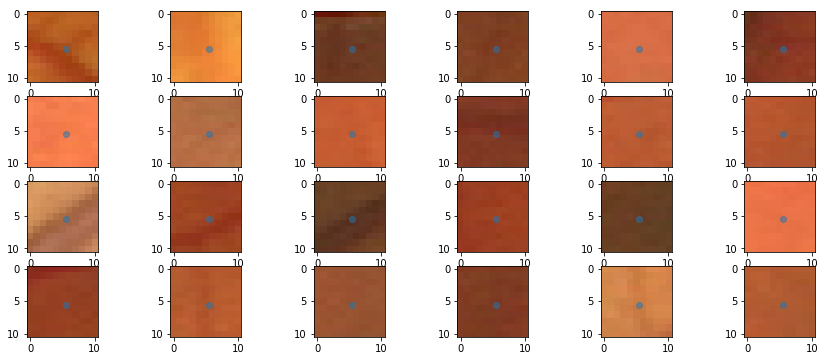

In [33]:
x, y = batch_creator.create_batch(24)
f, axes = plt.subplots(4, 6)
i = 0;
for ax_row in axes:
    for ax in ax_row:
        ax.imshow(x[i])
        ax.scatter(*[p/2 for p in patch_extractor.patch_size], alpha=0.5)
        i += 1
plt.show()

## Train the new network!

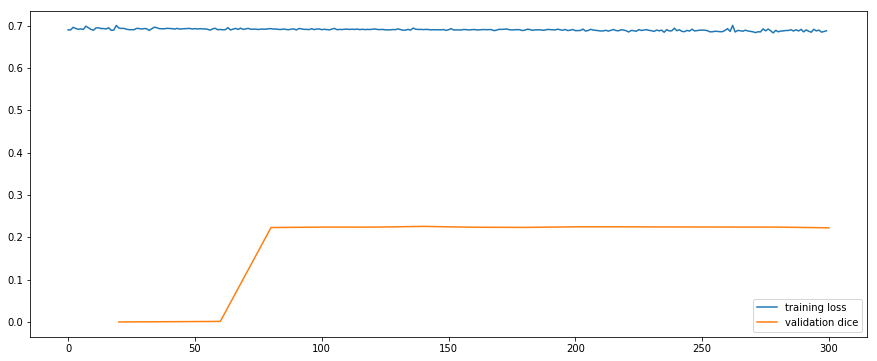

Epoch 16/250
20/20 [==============================] - ETA: 1s - loss: 0.689 - ETA: 1s - loss: 0.688 - ETA: 1s - loss: 0.689 - ETA: 1s - loss: 0.689 - ETA: 0s - loss: 0.688 - ETA: 0s - loss: 0.688 - ETA: 0s - loss: 0.688 - ETA: 0s - loss: 0.688 - ETA: 0s - loss: 0.688 - ETA: 0s - loss: 0.688 - ETA: 0s - loss: 0.688 - ETA: 0s - loss: 0.687 - ETA: 0s - loss: 0.687 - ETA: 0s - loss: 0.687 - ETA: 0s - loss: 0.687 - ETA: 0s - loss: 0.687 - ETA: 0s - loss: 0.687 - ETA: 0s - loss: 0.687 - ETA: 0s - loss: 0.687 - 1s 65ms/step - loss: 0.6869


In [ ]:
generator = batch_creator.get_generator(batch_size)

logger_2 = Logger(validation_data, patch_size, stride=stride)

model_2.fit_generator(generator=generator, 
                      steps_per_epoch=steps_per_epoch, 
                      epochs=epochs, 
                      callbacks=[logger_2])

## Check the performance of the new model

The new model does not reduce the resolution of the output image, so it can be applied directly to new images!
Let's see how well this model does.

In [ ]:
model_2.set_weights(logger_2.best_model)

lbls, msks, output =  process_basic(model_2, validation_data)
check_results(validation_data.imgs, lbls, msks, output, threshold=0.4)

## Submit to grand-challenge.org (again)
This time we use the function ```process_test_set```, because we didn't use shift and stitch.

In [ ]:
# define output folder
process_test_set(model_2, logger_2, test_imgs, test_msks, patch_size, stride)

In [ ]:
shutil.make_archive('results', 'zip', result_output_folder)

You can now download this zipfile with this link: [results.zip](results.zip).  
Next, upload your result to the challenge website (https://drive.grand-challenge.org/evaluation/submissions/create/) and see how well you performed compared to your fellow students! You can submit as often as you want, only the best result counts.  

## Network 3: dilated convolutions (10 pts)
<img align="right" width="300" src="images/dilation.gif">

You will notice that the performance of the last network for this task is still reasonable, even if we train on smaller patches. However, to get state-of-the-art results, it is sometimes necessary to include a larger context. If we wish to do this without introducing pooling operations or increasing the complexity of the network too much, we have another option: dilated convolutions.

Dilated convolutions work like regular convolutions, but introduce a spacing between the parameters of the filter. This way, they expand the area covered by the filter (often referred to as the **receptive field**). Unlike pooling operations, they do not reduce the resolution of the feature maps. Let's experiment with them, and define a new network architecture that includes dilated convolutions. See the image to the right for an example of a 3x3 convolution filter with dilation rate 2 (image taken from https://github.com/vdumoulin/conv_arithmetic).

Implement the following network
* input layer 
* 32 filters of 3x3
* 32 filters of 3x3
* 64 filters of 3x3, dilation rate 2
* 64 filters of 3x3, dilation rate 4
* 128 filters of 3x3, dilation rate 8
* 64 filters of 1x1
* 2 filters of 1x1 

In [ ]:
x_in = Input(batch_shape=(None, None, None, 3))

### Your code starts here
x = Conv2D(32, (3, 3), activation='relu')(x_in)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu', dilation_rate=(2,2))(x)
x = Conv2D(64, (3, 3), activation='relu', dilation_rate=(4,4))(x)
x = Conv2D(128, (3, 3), activation='relu', dilation_rate=(8,8))(x)
x = Conv2D(64, (1, 1), activation='relu')(x)
x_out = Conv2D(2, (1, 1), activation='softmax',)(x)

### 

model_3 = Model(x_in, x_out)
model_3.summary()

model_3.compile(optimizer, loss_function)

#### Question
What patch-size do we need to define in order to get an output size of 1x1 for the above network definition?

*Your answer here*

Set the new patch_size and stride for this network:

In [ ]:
patch_size = (33,33)
stride = 1

In [ ]:
patch_extractor = PatchExtractor(patch_size)
batch_creator = BatchCreator(patch_extractor, train_data)
patch_generator = batch_creator.get_generator(batch_size)

logger_3 = Logger(validation_data, patch_size, stride=stride)

In [ ]:
model_3.fit_generator(generator=patch_generator, 
                      steps_per_epoch=steps_per_epoch, 
                      epochs=epochs, 
                      callbacks=[logger_3])

Again, we will inspect the results on the validation set

In [ ]:
lbls, msks, output =  process_basic(model_3, validation_data)
check_results(validation_data.imgs, lbls, msks, output, threshold=0.5)

## Submit to grand-challenge (yes, again)

In [ ]:
# re-use previous code to process images segmented with the dilated network 
# and make a new submission to grand-challenge to check the performance on the test set

### YOUR CODE HERE

## Train on full images
The results with the dilated network don't look as good as the previous results yet. 
One reason for this could be that the network needs to aggregate more input data (larger patches) to a single label, and therefore may need longer training time. Let's see if we can do that more efficiently.

Instead of training on patches, we can actually use the entire image as input to the network, and apply the backpropagation over all pixels at the same time. This allows us to supply much more data to the network at a time. Let's try to fine-tune the dilated model by training for some more epochs on full images.

First, we will define the new generator and visualize the input to the network. Note the different shapes of the input image and label!

In [ ]:
image_generator = batch_creator.get_image_generator()

In [ ]:
# Execute this cell repeatedly to see different augmented images
im, label = next(image_generator)
print('input shape:', im.shape, 'output shape:', label.shape)
matplotlib.rcParams['figure.figsize'] = (15, 5)
f, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.imshow(im[0])
ax1.imshow(label[0,:,:,0], cmap='gray')
ax2.imshow(label[0,:,:,1], cmap='gray')
plt.show()

Executing the cell below will continue training the model, this time on full images.

In [ ]:
model_3.fit_generator(generator=image_generator, 
                      steps_per_epoch=10, 
                      epochs=100, 
                      callbacks=[logger_3])

In [ ]:
lbls, msks, output =  process_basic(model_3, validation_data)
check_results(validation_data.imgs, lbls, msks, output, threshold=0.5)

## Submit to grand-challenge.org (...and again...)

In [ ]:
# once again, re-use previous code to process images with this fine-tuned network
# and make a submission to grand-challenge.org

# Try to improve the results! (30 pts)
It is now up to you to pick a network architecture and a training strategy and try to get the best performance!

Here is an incomplete list of things you could experiment with:

- **Network architecture**: so far we've implemented 3 different network architecture, each with its pro's and cons. There are many other things you can try. You can play with the number of filters, the number of layers, adding drop-out or batch-normalization etc.

- **Training strategy**: we've implemented 2 different training strategies: patch-based or on full images. Maybe there are other options (alternating between the two, or selecting patches at hard locations to put more attention to the places where the network still fails).

- **Optimizer**: we've used SGD so far, maybe another optimizer would improve your results. Also try to experiment with the learning rate, or a apply a decay in the learning rate.

- **Augmentations**: we've only applied horizontal flipping to the patches and rotation to full images. Other useful augmentations may include non-linear deformations or gamma-corrections.

**NOTE:** Make sure your notebook can be executed cell by cell from top to bottom, so don't change the cells above, but instead add new cells below demonstrating your experiments

In [ ]:
# Add your experiments here
